# 04 - Applied ML

# Imports

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

# Constants definition

In [19]:
DATA_PATH = "./data"

 # Question 1: Propensity score matching

In [20]:
df = pd.read_csv("{}/lalonde.csv".format(DATA_PATH))
df.set_index('id', drop=True, inplace=True)

In [39]:
df['outcome'] = np.where( (df['re78'] - df['re75']) > 0 , 1, 0)

In [54]:
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,outcome
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,1
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,1
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,1
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,1
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,1


In [101]:
df[['educ', 'outcome', 'treat']].groupby(['educ', 'outcome']).count()

treat
educ outcome       
0    0            3
1    0            1
     1            1
2    1            2
3    0            2
     1            3
4    0            4
     1            5
5    0            3
     1            9
6    0            9
     1            3
7    0           13
     1           14
8    0           23
     1           39
9    0           23
     1           48
10   0           26
     1           61
11   0           30
     1           65
12   0           52
     1          105
13   0            8
     1           19
14   0            3
     1           18
15   0            3
     1            7
16   0            2
     1            6
17   1            2
18   0            1
     1            1

### 1. a naive approach

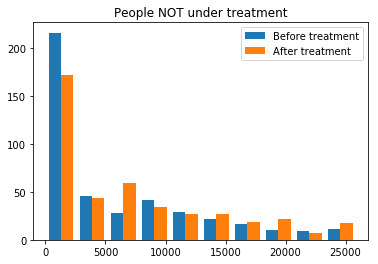

In [49]:
x = df[df["treat"] == 0]['re74']
y = df[df["treat"] == 0]['re78']

plt.hist( (x, y), label=('Before treatment', 'After treatment'))
plt.legend(loc='upper right')
plt.title("People NOT under treatment")
plt.show()

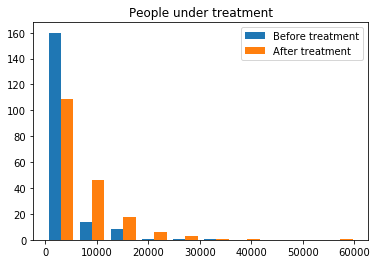

In [48]:
x = df[df["treat"] == 1]['re74']
y = df[df["treat"] == 1]['re78']

plt.hist( (x, y), label=('Before treatment', 'After treatment'))
plt.legend(loc='upper right')
plt.title("People under treatment")
plt.show()

### 3. A propensity score model

In the propensity score we want to obtain the probability to be under treatment according to the different covariates. In this case we will use the Logistic Regression Classifier to obtain a model for such task

In [ ]:
logistic = LogisticRegression()

The differen covariates of this problem are the following:

In [102]:
features = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree']

In [103]:
# The features vector
X = pd.get_dummies(df[features])
X.head()

,age,educ,black,hispan,married,nodegree
id,,,,,,
NSW1,37,11,1,0,1,1
NSW2,22,9,0,1,0,1
NSW3,30,12,1,0,0,0
NSW4,27,11,1,0,0,1
NSW5,33,8,1,0,0,1


We want to compute the probability of the treatment over the covariates. Our target will therefore be the treatment data

In [104]:
y = df['treat']

In [106]:
logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [124]:
logistic.classes_

array([0, 1])

In [128]:
pred = logistic.predict_proba(X)

df['propensity score'] = pred[:, 1]

df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,outcome,propensity score
id,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,1,0.473938
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,1,0.200786
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,1,0.642152
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,1,0.695664
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,1,0.677198


### 4. Balancing the dataset via matching

In [179]:
G = nx.Graph()
G.add_nodes_from([1,2,3,4], bipartite=0) # Add the node attribute "bipartite"
G.add_nodes_from(['a','b','c'], bipartite=1)
G.add_edges_from([(1,'a'), (1,'b'), (2,'b'), (2,'c'), (3,'c'), (4,'a')])

In [184]:
treated = df[df['treat'] == 1]['propensity score']
control = df[df['treat'] == 0]['propensity score']

In [185]:
B = nx.Graph()

B.add_nodes_from(treated[:5], bipartite=0)
B.add_nodes_from(control[:5], bipartite=1)

/Users/mfeo15/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/mfeo15/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/mfeo15/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/mfeo15/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold i

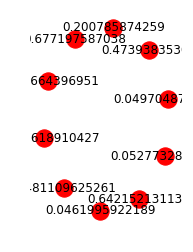

In [188]:
plt.subplot(121)
nx.draw(B, with_labels=True, font_weight='regular')

In [170]:
from networkx.algorithms import bipartite
a, b = bipartite.sets(B)

In [171]:
a

{0.47393835308019683}

In [172]:
nx.bipartite.maximum_matching(B)

{0.052773286422486174: 0.47393835308019683,
 0.47393835308019683: 0.052773286422486174}

 # Question 2: Applied ML

In [5]:
newsgroups_train = fetch_20newsgroups(data_home='{}/'.format(DATA_PATH) ,subset='all')

In [7]:
print(newsgroups_train.data[1], end="\n\n")

From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)
Subject: Which high-performance VLB video card?
Summary: Seek recommendations for VLB video card
Nntp-Posting-Host: midway.ecn.uoknor.edu
Organization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA
Keywords: orchid, stealth, vlb
Lines: 21

  My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:

  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

  - ATI Graphics Ultra Pro

  - Any other high-performance VLB card


Please post or email.  Thank you!

  - Matt

-- 
    |  Matthew B. Lawson <------------> (mblawson@essex.ecn.uoknor.edu)  |   
  --+-- "Now I, Nebuchadnezzar, praise and exalt and glorify the King  --+-- 
    |   of heaven, because everything he does is right and all his ways  |   
    |   are just." - Nebuchadnezzar, king of Babylon, 562 B.C.           |   




In [8]:
type(newsgroups_train)

sklearn.datasets.base.Bunch

In [9]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors.shape

(18846, 173762)

In [15]:
vectorizer.vocabulary_

{'from': 76869,
 'mamatha': 106418,
 'devineni': 63606,
 'ratnam': 133114,
 'mr47': 112961,
 'andrew': 39368,
 'cmu': 55748,
 'edu': 68505,
 'subject': 148466,
 'pens': 124549,
 'fans': 73535,
 'reactions': 133565,
 'organization': 121189,
 'post': 127449,
 'office': 119906,
 'carnegie': 52263,
 'mellon': 108761,
 'pittsburgh': 126093,
 'pa': 122831,
 'lines': 102149,
 '12': 4705,
 'nntp': 117497,
 'posting': 127481,
 'host': 86318,
 'po4': 126850,
 'am': 38772,
 'sure': 149368,
 'some': 145262,
 'bashers': 44327,
 'of': 119845,
 'are': 40752,
 'pretty': 128365,
 'confused': 57307,
 'about': 35817,
 'the': 152603,
 'lack': 100011,
 'any': 39915,
 'kind': 97718,
 'posts': 127509,
 'recent': 133857,
 'massacre': 107112,
 'devils': 63603,
 'actually': 36499,
 'bit': 46354,
 'puzzled': 130016,
 'too': 154228,
 'and': 39315,
 'relieved': 134797,
 'however': 86456,
 'going': 80464,
 'to': 153971,
 'put': 129989,
 'an': 39151,
 'end': 69947,
 'non': 117647,
 'pittsburghers': 126095,
 'relief'

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
clf = DecisionTreeClassifier()

In [40]:
newsgroups_test = fetch_20newsgroups(data_home='{}/'.format(DATA_PATH) ,subset='test')
vectors_test = vectorizer.transform(newsgroups_train.data)

clf.fit(vectors, newsgroups_train.target)
pred = clf.predict(vectors_test)

metrics.f1_score(newsgroups_test.target, pred, average='macro')

ValueError: Found input variables with inconsistent numbers of samples: [7532, 11314]